In [1]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
import pandas as pd
import re
import numpy.ma as ma

from copy import deepcopy
from corner import corner
from custom_corner_core import custom_corner_impl

from taurex.binning.fluxbinner import FluxBinner
from taurex.util.util import wnwidth_to_wlwidth

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

WDIR = Path().cwd().parent


Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
def get_target_results(path=None):
    if path is None:
        path = Path(WDIR / "data/synthetic_spectra/WASP-39b")

    path = Path(path)

    paths = Path(path).rglob("*_output.hdf5")
    paths = list(paths)
    results = [""] * len(paths)

    for i, res in enumerate(paths):
        results[i] = h5py.File(res, "r")

    for i, res in enumerate(results):
        try:
            __ = res['Observed']
            __ = res['Output']['Solutions']
        except KeyError:
            print(f"{paths[i].name} does not have Observed or Solutions")

    return results, paths


results, paths = get_target_results()

In [3]:
def split_on_underscore(s):
    s = s.replace("spectral_element", "spectral-element")
    pattern = r'(?<!\()_(?!\))'
    temp_parts = re.split(pattern, s)
    parts = []
    i = 0
    while i < len(temp_parts):
        part = temp_parts[i]
        if '(' in part and ')' not in part:
            combined_parts = [part]
            i += 1
            while i < len(temp_parts) and ')' not in temp_parts[i]:
                combined_parts.append(temp_parts[i])
                i += 1
            combined_parts.append(temp_parts[i])
            parts.append('_'.join(combined_parts))
        else:
            parts.append(part)
        i += 1
    return parts

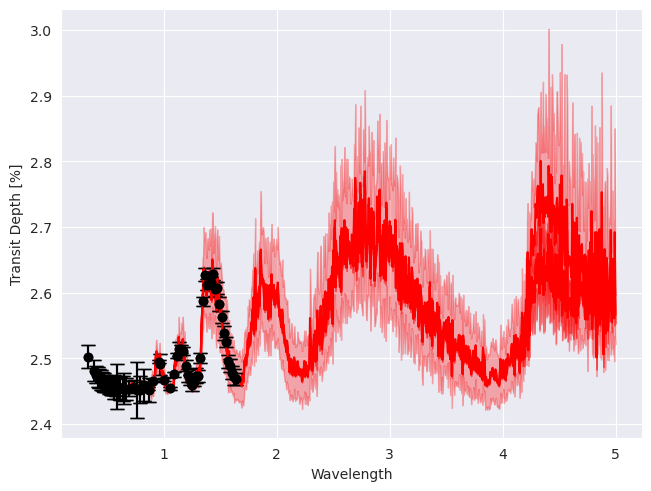

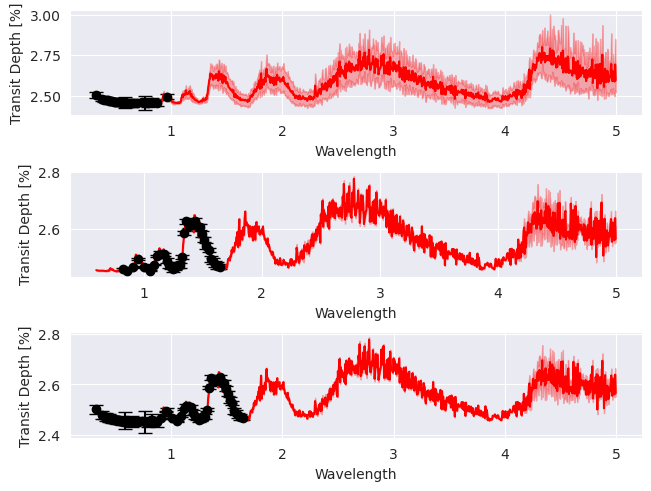

In [4]:
def bin_spectrum(low_res, high_res):
    transmission_spectra = high_res.sort_values(by='wavelength')
    low_res = low_res.sort_values(by='wavelength')
    low_res = low_res.reset_index(drop=True)

    binner = FluxBinner(low_res['wavelength'].values)

    _, binned_transit_depth, _, _ = binner.bindown(transmission_spectra['wavelength'].values,
                                                   transmission_spectra['depth'].values)

    return np.array(binned_transit_depth)


def plot_spectrum_into_ax(hdf5file=None, outfile=None, ax=None):
    if hdf5file is None:
        pass
    if outfile is None:
        pass

    if ax is None:
        ax = plt.gca()

    if isinstance(hdf5file, (str, Path)):
        res = h5py.File(hdf5file, 'r')
    elif isinstance(hdf5file, h5py.File):
        res = hdf5file
    else:
        raise NotImplementedError

    res_spec = res['Output']['Solutions']['solution0']['Spectra']
    factor = 1e2

    hr = pd.DataFrame(res_spec['native_wlgrid'][()], columns=['wavelength'])
    hr['depth'] = res_spec['native_spectrum'][()]

    bd = 0.005
    lr = pd.DataFrame(np.arange(0.6, 5, bd), columns=['wavelength'])
    lr['depth'] = bin_spectrum(lr.copy(), hr)

    hr_plus_std = hr.copy()
    hr_plus_std['depth'] = res_spec['native_spectrum'][()] + res_spec['native_std'][()]

    hr_minus_std = hr.copy()
    hr_minus_std['depth'] = res_spec['native_spectrum'][()] - res_spec['native_std'][()]

    lr['depth_m_std'] = bin_spectrum(lr.copy(), hr_minus_std)
    lr['depth_p_std'] = bin_spectrum(lr.copy(), hr_plus_std)

    try:
        ax.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()] * factor,
                    yerr=res['Observed']['errorbars'][()] * factor,
                    fmt='o', c='k', capsize=5)
    except KeyError:
        pass
    ax.plot(lr['wavelength'], lr['depth'] * factor, c='r')
    ax.fill_between(lr['wavelength'], lr['depth_m_std'] * factor, lr['depth_p_std'] * factor, color='r', alpha=0.3)
    # ax.set_xlim(0.85, 1.7)
    # ax.set_ylim(2.01, 2.17)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Transit Depth [%]')
    return ax


fig, ax = plt.subplots(1, 1, num="spectrum_differences", constrained_layout=True)

for i, file in enumerate(results):
    ax = plot_spectrum_into_ax(file)

# filename = Path(model_files[0]).parent / "spectrum_differences.png"
# plt.savefig(filename, dpi=300)

fig, axes = plt.subplots(len(results), 1, num="stacked_spectrum_differences", constrained_layout=True)

axes = np.array(axes).flatten()

for i, (file, ax) in enumerate(zip(results, axes)):
    plt.sca(ax)
    ax = plot_spectrum_into_ax(file)

/tmp/ipykernel_1181480/813834391.py:156: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_rainbow', n)


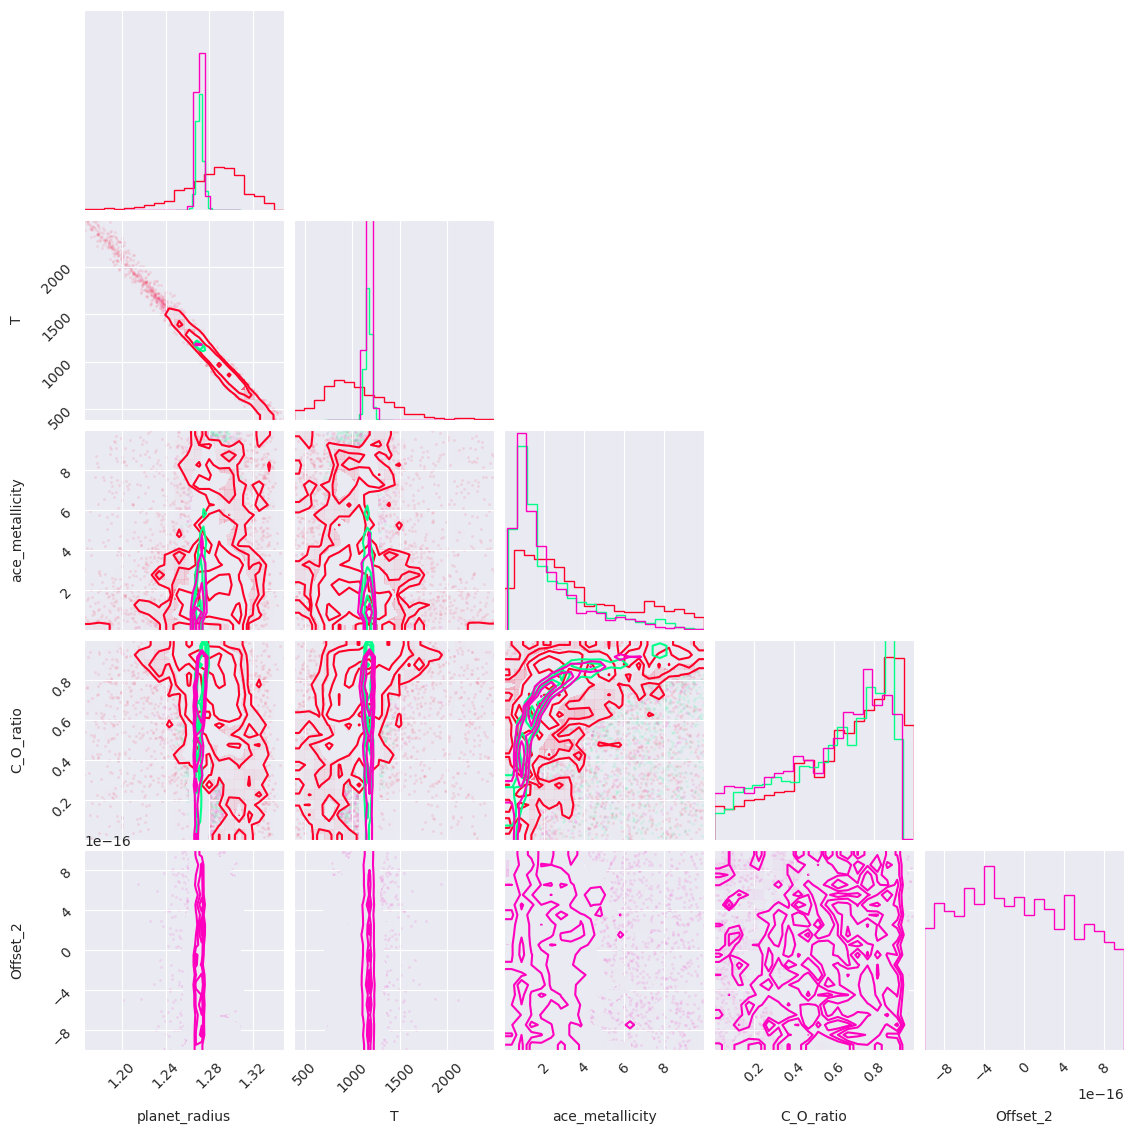

In [30]:
CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=5,
    quiet=True,
)

def merge_data_sets(data_sets):
    all_data = pd.DataFrame()
    for data in data_sets:
        df = pd.DataFrame(data)
        all_data = pd.concat([all_data, df], axis=0)
    return all_data

def make_struct_df(results, paths):
    names = [p.stem for p in paths]
    split_names = [split_on_underscore(name) for name in names]

    labels = [
        f'{nlist[2].replace("instrument(", "").replace(")", "")}'.replace("_", "+")
        for nlist in split_names
    ]

    dfs = []
    for i, (res, p) in enumerate(zip(results, paths)):
        par_names = [n[0].decode("utf-8") for n in res['Optimizer']['fit_parameter_names']]
        trace = res['Output']['Solutions']['solution0']['tracedata'][()]
        weights = res['Output']['Solutions']['solution0']['weights'][()]
        name = names[i]
        label = labels[i]

        df = pd.DataFrame(
            trace, columns=par_names
        )

        df["weights"] = weights
        df["name"] = name
        df["label"] = label

        dfs.append(df)

    return merge_data_sets(dfs)

def get_normalisation_weights(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)

def make_meta_corner(results, fig=None):
    dfs = []

    lens = []

    for i, res in enumerate(results):
        par_names = [n[0].decode("utf-8") for n in res['Optimizer']['fit_parameter_names']]
        trace = res['Output']['Solutions']['solution0']['tracedata'][()]
        weights = res['Output']['Solutions']['solution0']['weights'][()]

        lens.append(len(weights))

        df = pd.DataFrame(
            trace, columns=par_names
        )

        df["weights"] = weights

        dfs.append(df)

    df = merge_data_sets(dfs)

    def replace_nans(df):
        for column in df.columns:
            mask = df[column].isna()

            new = df.loc[~mask, column].sample(sum(mask),
                                               weights=df.loc[~mask, "weights"].to_numpy(),
                                               replace=True,
                                               ).to_numpy()

            df.loc[mask, column] = new
        return df

    df = replace_nans(df)

    labels = [c for c in df.columns if c != "weights"]
    data = df[labels]

    norms = np.array(lens) / np.max(lens)

    fig = corner(
        data=data,
        fig=fig,
        weights=df["weights"] / len(results),
        show_titles=False,
        labels=labels,
        hist_kwargs={"alpha": 0.},
        contour_kwargs={"alpha": 0.},
        contourf_kwargs={"alpha": 0.},
        data_kwargs={"alpha": 0.},
        pcolor_kwargs={"alpha": 0.},
        alpha=0.,
    )


    return fig, norms

def make_sub_corner(fig, result, path, color="k", norm=1.):
    name = path.stem
    split_name = split_on_underscore(name)
    label = f'{split_name[2].replace("instrument(", "").replace(")", "")}'.replace("_", "+")

    trace = result['Output']['Solutions']['solution0']['tracedata'][()]
    weights = result['Output']['Solutions']['solution0']['weights'][()]
    parameter_names = [n[0].decode("utf-8") for n in result['Optimizer']['fit_parameter_names']]
    solutions = result['Output']['Solutions']['solution0']['fit_params']

    data = {k: trace[:, i].flatten() for i, k in enumerate(parameter_names)}
    # [print(data[k].shape) for k in data.keys()]
    #
    # print(parameter_names)
    #
    # print(trace.shape)
    # print(weights.shape)

    if fig is None:
        fig = plt.gcf()

    fig = custom_corner_impl(
        # data,
        trace,
        fig=fig,
        weights=weights,
        color=color,
        labels=parameter_names
    )

    return fig

def overplot_corners_new(results=None, paths=None):

    n = len(results)

    names = [p.stem for p in paths]
    split_names = [split_on_underscore(name) for name in names]

    labels = [
        f'{nlist[2].replace("instrument(", "").replace(")", "")}'.replace("_", "+")
        for nlist in split_names
    ]

    cmap = plt.cm.get_cmap('gist_rainbow', n)
    colors = [cmap(i) for i in range(n)]



    fig, norms = make_meta_corner(results)

    for result, path, color, norm in zip(results, paths, colors, norms):

        fig = make_sub_corner(fig,
                              result,
                              path,
                              color=color,
                              norm=norm,
                              )

    fig, __ = make_meta_corner(results, fig=fig)

    filename = Path(paths[0]).parent.parent / "corner.png"
    plt.savefig(filename, dpi=300)

    # for p in axes_dims:
    #     print(p)

    # data_labels = [k for k in samples.keys() if k in labels]

    # for i in range(ndim):
    #     ax = axes[i, i]
    #     ax.annotate(f"{i}: x- {ax.get_xlabel()}, y- {ax.get_ylabel()}", (0.5, 0.5), xycoords='axes fraction',
    #                 ha="center")
    #
    # for yi in range(ndim):
    #     for xi in range(yi):
    #         ax = axes[yi, xi]
    #         ax.annotate(f"{yi}x{xi}: x- {ax.get_xlabel()}, y- {ax.get_ylabel()}", (0.5, 0.5), xycoords='axes fraction',
    #                     ha="center")


    # for idx, result in zip(range(1, n), results):
    #     fig = corner(
    #         traces[idx],
    #         fig=fig,
    #         # weights=weights[idx],  # get_normalisation_weight(len(traces), max_len),
    #         color=colors[idx],
    #         # truths=final_para,
    #         **CORNER_KWARGS
    #     )

    # plt.legend(
    #     handles=[
    #         mlines.Line2D([], [], color=colors[i], label=labels[i])
    #         for i in range(n)
    #     ],
    #     fontsize=20, frameon=False,
    #     bbox_to_anchor=(1, ndim), loc="upper right"
    # )


In [12]:
for name, h5obj in results[0].items():
    if isinstance(h5obj, h5py.Group):
        print(name, 'is a Group')
    elif isinstance(h5obj, h5py.Dataset):
        print(name, 'is a Dataset')
        # return a np.array using dataset object:
        arr1 = h5obj[:]
        # return a np.array using dataset name:
        arr2 = results[0][name][:]
        # compare arr1 to arr2 (should always return True):
        print(np.array_equal(arr1, arr2))

def print_attrs(name, obj):
    if name.count('/') > 1 and "Solutions/solution0" not in name:
        return
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")


results[0].visititems(print_attrs)

ModelParameters is a Group
Observed is a Group
Optimizer is a Group
Output is a Group
ModelParameters
    ModelParameters/Chemistry
    ModelParameters/Contributions
    ModelParameters/Planet
    ModelParameters/Pressure
    ModelParameters/Star
    ModelParameters/Temperature
    ModelParameters/model_type
Observed
    Observed/binedges
    Observed/binwidths
    Observed/errorbars
    Observed/spectrum
    Observed/wlgrid
Optimizer
    Optimizer/constant_efficiency
    Optimizer/derived_parameter_latex
    Optimizer/derived_parameter_names
    Optimizer/evidence_tolerance
    Optimizer/fit_boundary_high
    Optimizer/fit_boundary_low
    Optimizer/fit_parameter_latex
    Optimizer/fit_parameter_names
    Optimizer/importance_sampling 
    Optimizer/max_iterations
    Optimizer/max_modes
    Optimizer/mode_tolerance
    Optimizer/nclust_parameter
    Optimizer/num_live_points
    Optimizer/optimizer
    Optimizer/sampling_eff 
    Optimizer/search_multimodes
Output
    Output/Priors


In [ ]:
dirs = [WDIR / "data/synthetic_spectra/WASP-39b/syn_offset/"]



In [ ]:
def _plot_divergence(results, paths):
    import divergence as dv

    par_names = []
    traces = []
    weights = []

    for i, res in enumerate(results):
        par_name = [n[0].decode("utf-8") for n in res['Optimizer']['fit_parameter_names']]
        trace = res['Output']['Solutions']['solution0']['tracedata'][()]
        weight = res['Output']['Solutions']['solution0']['weights'][()]

        print(dv.continuous_entropy_from_sample(trace))

        par_names.append(par_name)
        traces.append(trace)
        weights.append(weight)

    return


def plot_divergence(path=None):
    results, paths = get_target_results(path=path)

    _plot_divergence(results, paths)

    plt.gcf()
    filename = Path(paths[0]).parent.parent / "corner.png"
    plt.savefig(filename, dpi=300)
